# Preprocessing - Basic feature selection

Before performing All Relevant Feature Selection, you might want to apply preprocessing or basic feature selection to remove columns with:

 - a lot of missing values
 - zero variance
 - high cardinality
 - highly correlated (and keep only one)
 - zero predictive power
 - low predictive power

Any of those steps can be ignored but I recommend at least removing highly correlated predictors if you don't have a good reason for keeping them in the dataset.


In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# Settings and libraries
from __future__ import print_function

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import gc

import arfs
import arfs.preprocessing as arfspp
import arfs.feature_selection as arfsfs
from arfs.utils import (
    _make_corr_dataset_regression,
    _make_corr_dataset_classification,
)

%matplotlib inline

In [3]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 2.2.0


In [4]:
arfsfs.__all__

['BaseThresholdSelector',
 'MissingValueThreshold',
 'UniqueValuesThreshold',
 'CardinalityThreshold',
 'CollinearityThreshold',
 'VariableImportance',
 'make_fs_summary',
 'Leshy',
 'BoostAGroota',
 'GrootCV',
 'MinRedundancyMaxRelevance',
 'LassoFeatureSelection']

Generating artificial data, inspired by the BorutaPy unit test

In [5]:
X, y, w = _make_corr_dataset_regression()
data = X.copy()
data["target"] = y

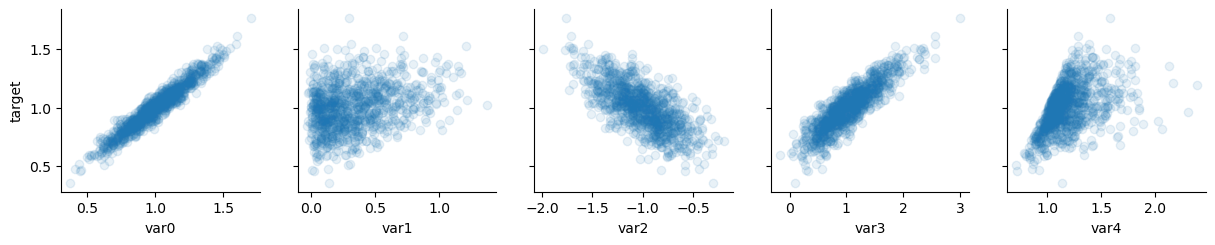

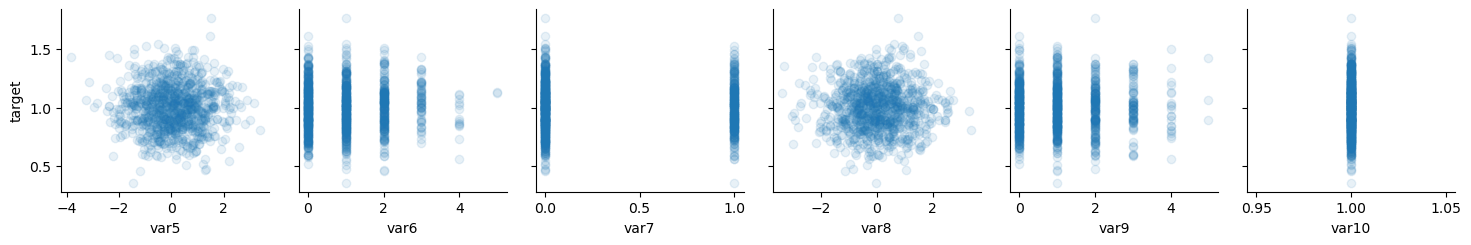

In [6]:
# significant regressors
x_vars = ["var0", "var1", "var2", "var3", "var4"]
y_vars = ["target"]
g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
g.map(plt.scatter, alpha=0.1)

# noise
x_vars = ["var5", "var6", "var7", "var8", "var9", "var10"]
y_vars = ["target"]
g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
g.map(plt.scatter, alpha=0.1)

plt.plot();

In [7]:
X.head()

var0      var1      var2      var3      var4      var5  var6  var7  \
0  1.016361  0.821664 -1.184095  0.985738  1.050445 -0.494190     2     0   
1  0.929581  0.334013 -1.063030  0.819273  1.016252  0.283845     1     0   
2  1.095456  0.187234 -1.488666  1.087443  1.140542  0.962503     2     0   
3  1.318165  0.994528 -1.370624  1.592398  1.315021  1.165595     0     0   
4  0.849496  0.184859 -0.806604  0.865702  0.991916 -0.058833     1     0   

       var8  var9  var10 var11     var12       nice_guys  
0 -0.361717     1    1.0     0  1.705980            Bias  
1  0.178670     2    1.0     1       NaN           Klaue  
2 -3.375579     2    1.0     2       NaN  Imaginedragons  
3 -0.449650     2    1.0     3  2.929707           MarkZ  
4  0.763903     1    1.0     4       NaN          Thanos

In [8]:
X.dtypes

var0          float64
var1          float64
var2          float64
var3          float64
var4          float64
var5          float64
var6            int32
var7            int32
var8          float64
var9            int32
var10         float64
var11        category
var12         float64
nice_guys      object
dtype: object

In [9]:
X.nunique()

var0         1000
var1         1000
var2         1000
var3         1000
var4         1000
var5         1000
var6            6
var7            2
var8         1000
var9            6
var10           1
var11         500
var12         500
nice_guys      36
dtype: int64

In [10]:
y = pd.Series(y)
y.name = "target"

## Removing columns with many missing values

In [11]:
# X is the predictor DF (e.g: df[predictor_list]), at this stage you don't need to
# specify the target and weights (only for identifying zero and low importance)

# unsupervised learning, doesn't need a target
selector = arfsfs.MissingValueThreshold(0.05)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True  True  True  True  True  True  True
 False  True]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'nice_guys']


In [12]:
X_trans.head()

var0      var1      var2      var3      var4      var5  var6  var7  \
0  1.016361  0.821664 -1.184095  0.985738  1.050445 -0.494190     2     0   
1  0.929581  0.334013 -1.063030  0.819273  1.016252  0.283845     1     0   
2  1.095456  0.187234 -1.488666  1.087443  1.140542  0.962503     2     0   
3  1.318165  0.994528 -1.370624  1.592398  1.315021  1.165595     0     0   
4  0.849496  0.184859 -0.806604  0.865702  0.991916 -0.058833     1     0   

       var8  var9  var10 var11       nice_guys  
0 -0.361717     1    1.0     0            Bias  
1  0.178670     2    1.0     1           Klaue  
2 -3.375579     2    1.0     2  Imaginedragons  
3 -0.449650     2    1.0     3           MarkZ  
4  0.763903     1    1.0     4          Thanos

In [13]:
X.head()

var0      var1      var2      var3      var4      var5  var6  var7  \
0  1.016361  0.821664 -1.184095  0.985738  1.050445 -0.494190     2     0   
1  0.929581  0.334013 -1.063030  0.819273  1.016252  0.283845     1     0   
2  1.095456  0.187234 -1.488666  1.087443  1.140542  0.962503     2     0   
3  1.318165  0.994528 -1.370624  1.592398  1.315021  1.165595     0     0   
4  0.849496  0.184859 -0.806604  0.865702  0.991916 -0.058833     1     0   

       var8  var9  var10 var11     var12       nice_guys  
0 -0.361717     1    1.0     0  1.705980            Bias  
1  0.178670     2    1.0     1       NaN           Klaue  
2 -3.375579     2    1.0     2       NaN  Imaginedragons  
3 -0.449650     2    1.0     3  2.929707           MarkZ  
4  0.763903     1    1.0     4       NaN          Thanos

## Removing columns with zero variance

In [14]:
# single unique value(s) columns
# here rejecting columns with (or less than) 2 unique values
# unsupervised learning, doesn't need a target
selector = arfsfs.UniqueValuesThreshold(threshold=2)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True  True False  True  True False  True
  True  True]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var8' 'var9' 'var11'
 'var12' 'nice_guys']


In [15]:
X_trans.head()

var0      var1      var2      var3      var4      var5  var6      var8  \
0  1.016361  0.821664 -1.184095  0.985738  1.050445 -0.494190     2 -0.361717   
1  0.929581  0.334013 -1.063030  0.819273  1.016252  0.283845     1  0.178670   
2  1.095456  0.187234 -1.488666  1.087443  1.140542  0.962503     2 -3.375579   
3  1.318165  0.994528 -1.370624  1.592398  1.315021  1.165595     0 -0.449650   
4  0.849496  0.184859 -0.806604  0.865702  0.991916 -0.058833     1  0.763903   

   var9 var11     var12       nice_guys  
0     1     0  1.705980            Bias  
1     2     1       NaN           Klaue  
2     2     2       NaN  Imaginedragons  
3     2     3  2.929707           MarkZ  
4     1     4       NaN          Thanos

In [16]:
X.head()

var0      var1      var2      var3      var4      var5  var6  var7  \
0  1.016361  0.821664 -1.184095  0.985738  1.050445 -0.494190     2     0   
1  0.929581  0.334013 -1.063030  0.819273  1.016252  0.283845     1     0   
2  1.095456  0.187234 -1.488666  1.087443  1.140542  0.962503     2     0   
3  1.318165  0.994528 -1.370624  1.592398  1.315021  1.165595     0     0   
4  0.849496  0.184859 -0.806604  0.865702  0.991916 -0.058833     1     0   

       var8  var9  var10 var11     var12       nice_guys  
0 -0.361717     1    1.0     0  1.705980            Bias  
1  0.178670     2    1.0     1       NaN           Klaue  
2 -3.375579     2    1.0     2       NaN  Imaginedragons  
3 -0.449650     2    1.0     3  2.929707           MarkZ  
4  0.763903     1    1.0     4       NaN          Thanos

## Removing columns with high cardinality

Large cardinality or many unique values are known to be favoured by tree-based models.

In [17]:
# high cardinality for categoricals predictors
# unsupervised learning, doesn't need a target
selector = arfsfs.CardinalityThreshold(threshold=100)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True  True  True  True  True  True False
  True  True]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var12' 'nice_guys']


In [18]:
X_trans.head()

var0      var1      var2      var3      var4      var5  var6  var7  \
0  1.016361  0.821664 -1.184095  0.985738  1.050445 -0.494190     2     0   
1  0.929581  0.334013 -1.063030  0.819273  1.016252  0.283845     1     0   
2  1.095456  0.187234 -1.488666  1.087443  1.140542  0.962503     2     0   
3  1.318165  0.994528 -1.370624  1.592398  1.315021  1.165595     0     0   
4  0.849496  0.184859 -0.806604  0.865702  0.991916 -0.058833     1     0   

       var8  var9  var10     var12       nice_guys  
0 -0.361717     1    1.0  1.705980            Bias  
1  0.178670     2    1.0       NaN           Klaue  
2 -3.375579     2    1.0       NaN  Imaginedragons  
3 -0.449650     2    1.0  2.929707           MarkZ  
4  0.763903     1    1.0       NaN          Thanos

In [19]:
X.head()

var0      var1      var2      var3      var4      var5  var6  var7  \
0  1.016361  0.821664 -1.184095  0.985738  1.050445 -0.494190     2     0   
1  0.929581  0.334013 -1.063030  0.819273  1.016252  0.283845     1     0   
2  1.095456  0.187234 -1.488666  1.087443  1.140542  0.962503     2     0   
3  1.318165  0.994528 -1.370624  1.592398  1.315021  1.165595     0     0   
4  0.849496  0.184859 -0.806604  0.865702  0.991916 -0.058833     1     0   

       var8  var9  var10 var11     var12       nice_guys  
0 -0.361717     1    1.0     0  1.705980            Bias  
1  0.178670     2    1.0     1       NaN           Klaue  
2 -3.375579     2    1.0     2       NaN  Imaginedragons  
3 -0.449650     2    1.0     3  2.929707           MarkZ  
4  0.763903     1    1.0     4       NaN          Thanos

## Removing columns highly correlated

REM: if the matrix is not of full rank (as with a constant column), warnings will be printed.

In [20]:
# unsupervised learning, doesn't need a target
selector = arfsfs.CollinearityThreshold(threshold=0.85, n_jobs=1)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

{'var10'} columns have been removed (single unique values)
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True  True  True  True  True  True False
  True  True]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var12' 'nice_guys']


In [21]:
selector.assoc_matrix_

nice_guys      var0      var1  var10     var11     var12      var2  \
nice_guys   0.000000  0.294977  0.258632    0.0  0.898225  0.280449  0.248837   
var0        0.294977  0.000000  0.302874    0.0  0.854820  0.666992 -0.651981   
var1        0.258632  0.302874  0.000000    0.0  0.868096  0.216084 -0.184429   
var10       0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000   
var11       0.544415  0.854820  0.868096    0.0  0.000000  0.849764  0.872079   
var12       0.280449  0.666992  0.216084    0.0  0.849764  0.000000 -0.512130   
var2        0.248837 -0.651981 -0.184429    0.0  0.872079 -0.512130  0.000000   
var3        0.304239  0.843940  0.232141    0.0  0.847803  0.651668 -0.591345   
var4        0.310595  0.418906  0.142912    0.0  0.838437  0.273527 -0.265794   
var5        0.246047  0.009898  0.066035    0.0  0.868140  0.009298 -0.009088   
var6        0.239888  0.064060  0.064463    0.0  0.865499 -0.025215 -0.079217   
var7        0.349974 -0.010704 -0.029047    0.0  0.879649  0.024897 -0.069979   
var8        0.260776  0.018960  0.048761    0.0  0.873458  0.035544 -0.014900   
var9        0.229026 -0.067228  0.009011    0.0  0.857720 -0.018271 -0.002299   

               var3      var4      var5      var6      var7      var8  \
nice_guys  0.304239  0.310595  0.246047  0.239888  0.349974  0.260776   
var0       0.843940  0.418906  0.009898  0.064060 -0.010704  0.018960   
var1       0.232141  0.142912  0.066035  0.064463 -0.029047  0.048761   
var10      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
var11      0.847803  0.838437  0.868140  0.865499  0.879649  0.873458   
var12      0.651668  0.273527  0.009298 -0.025215  0.024897  0.035544   
var2      -0.591345 -0.265794 -0.009088 -0.079217 -0.069979 -0.014900   
var3       0.000000  0.396321  0.005936  0.017144 -0.031763 -0.003174   
var4       0.396321  0.000000 -0.036836  0.075714 -0.053947 -0.019684   
var5       0.005936 -0.036836  0.000000  0.068218 -0.014902  0.006391   
var6       0.017144  0.075714  0.068218  0.000000  0.026035 -0.014477   
var7      -0.031763 -0.053947 -0.014902  0.026035  0.000000 -0.024883   
var8      -0.003174 -0.019684  0.006391 -0.014477 -0.024883  0.000000   
var9      -0.045243 -0.023970 -0.041267  0.027773 -0.011345  0.012951   

               var9  
nice_guys  0.229026  
var0      -0.067228  
var1       0.009011  
var10      0.000000  
var11      0.857720  
var12     -0.018271  
var2      -0.002299  
var3      -0.045243  
var4      -0.023970  
var5      -0.041267  
var6       0.027773  
var7      -0.011345  
var8       0.012951  
var9       0.000000

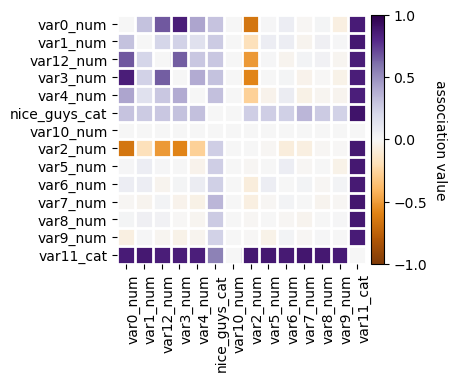

In [22]:
f = selector.plot_association()

  * the Correlation Ratio, for categorical-continuous association. Answers the question - given a continuous value of a measurement, is it possible to know which category is it associated with? Value is in the range $[0,1]$, where 0 means a category cannot be determined by a continuous measurement, and 1 means a category can be determined with absolute certainty
  * Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association. This is the uncertainty of x given y: value is on the range of $[0,1]$ - where 0 means y provides no information about x, and 1 means y provides full information about x. This is an asymmetric coefficient: $U(x,y) \neq U(y,x)$

In [23]:
X.shape

(1000, 14)

## Removing columns with zero or low predictive power

Identify the features with zero importance according to a gradient boosting machine. The lightgbm can be trained with early stopping using a utils set to prevent overfitting. The feature importances are averaged over `n_iterations` to reduce variance. Shapley values are used as feature importance for better results. If some predictors need to be encoded, integer encoding is chosen because OHE might lead to deep and unstable trees and lightGBM works great with integer encoding (see lightGBM doc).

In [24]:
lgb_kwargs = {"objective": "rmse", "zero_as_missing": False}
selector = arfsfs.VariableImportance(
    verbose=2, threshold=0.99, lgb_kwargs=lgb_kwargs, fastshap=False
)
X_trans = selector.fit_transform(X=X, y=y, sample_weight=w)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

  0%|          | 0/10 [00:00<?, ?it/s]

The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True False False  True False False  True
  True False]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var8' 'var11' 'var12']


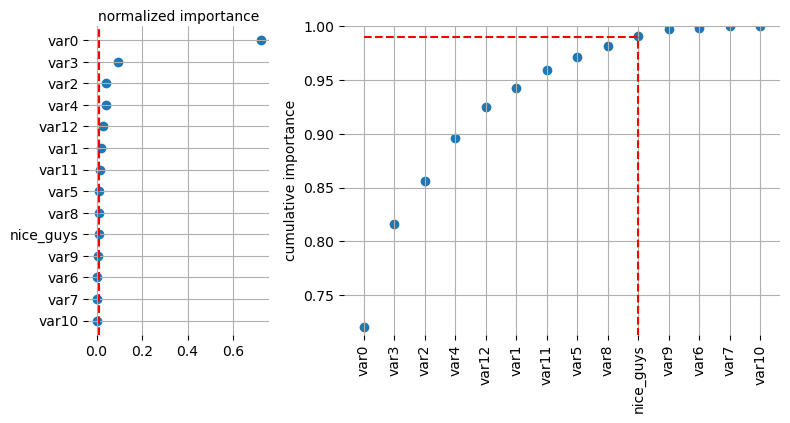

In [25]:
selector.plot_importance(log=False, style=None)

enable [fasttreeshap](https://engineering.linkedin.com/blog/2022/fasttreeshap--accelerating-shap-value-computation-for-trees) implementation

In [26]:
lgb_kwargs = {"objective": "rmse", "zero_as_missing": False}
selector = arfsfs.VariableImportance(
    verbose=2, threshold=0.99, lgb_kwargs=lgb_kwargs, fastshap=True
)
X_trans = selector.fit_transform(X=X, y=y, sample_weight=w)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

  0%|          | 0/10 [00:00<?, ?it/s]

The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True False False  True False False  True
  True False]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var8' 'var11' 'var12']


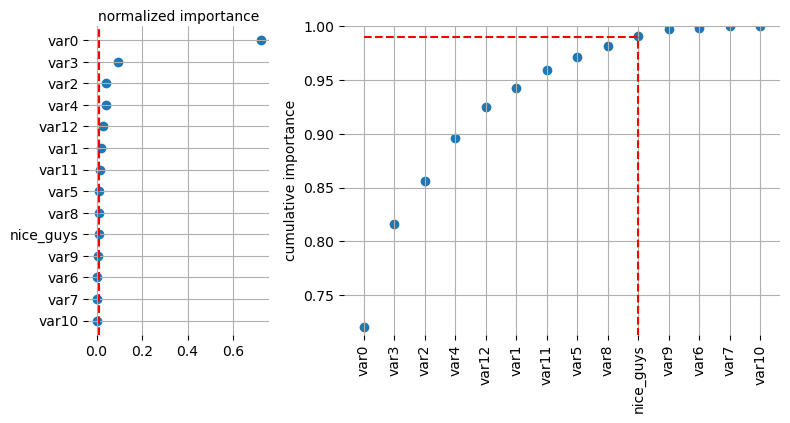

In [27]:
selector.plot_importance(log=False, style=None)

## All at once - Sklearn Pipeline

The selectors follow the scikit-learn base class, therefore they are compatible with scikit-learn in general.
This has several advantages:
 - easier to maintain
 - easier to version
 - more flexible
 - running faster by removing unnecessary columns before going to the computational demanding steps


In [28]:
from arfs.preprocessing import dtype_column_selector

cat_features_selector = dtype_column_selector(
    dtype_include=["category", "object", "bool"],
    dtype_exclude=[np.number],
    pattern=None,
    exclude_cols=["nice_guys"],
)

cat_features_selector(X)

['var11']

In [29]:
from sklearn.pipeline import Pipeline
from arfs.preprocessing import OrdinalEncoderPandas

encoder = Pipeline(
    [
        ('zero_variance', arfsfs.UniqueValuesThreshold()),
        ("collinearity", arfsfs.CollinearityThreshold(threshold=0.75)),
        ("encoder", OrdinalEncoderPandas()),
    ]
)
X_encoded = encoder.fit(X).transform(X)

In [30]:
encoder.fit(X)

Pipeline(steps=[('zero_variance', UniqueValuesThreshold()),
                ('collinearity', CollinearityThreshold(threshold=0.75)),
                ('encoder', OrdinalEncoderPandas())])

In [31]:
X_encoded = OrdinalEncoderPandas().fit_transform(X)
X_encoded

var0      var1      var2      var3      var4      var5  var6  var7  \
0    1.016361  0.821664 -1.184095  0.985738  1.050445 -0.494190     2     0   
1    0.929581  0.334013 -1.063030  0.819273  1.016252  0.283845     1     0   
2    1.095456  0.187234 -1.488666  1.087443  1.140542  0.962503     2     0   
3    1.318165  0.994528 -1.370624  1.592398  1.315021  1.165595     0     0   
4    0.849496  0.184859 -0.806604  0.865702  0.991916 -0.058833     1     0   
..        ...       ...       ...       ...       ...       ...   ...   ...   
995  0.904073  0.009764 -0.909486  0.831147  1.041658  0.081291     0     0   
996  1.370908  1.144173 -1.129008  2.002148  1.418488  0.484591     0     1   
997  1.113773  0.206798 -1.371649  1.167287  1.079760  0.267475     0     0   
998  0.905654  0.598419 -0.792174  0.783557  1.275266  0.380826     1     0   
999  1.138102  0.143818 -1.348573  1.321900  1.309521  1.342722     1     0   

         var8  var9  var10  var11     var12  nice_guys  
0   -0.361717     1    1.0    0.0  1.705980        4.0  
1    0.178670     2    1.0    1.0       NaN       21.0  
2   -3.375579     2    1.0    2.0       NaN       19.0  
3   -0.449650     2    1.0    3.0  2.929707       25.0  
4    0.763903     1    1.0    4.0       NaN       32.0  
..        ...   ...    ...    ...       ...        ...  
995 -0.542799     3    1.0  495.0       NaN       10.0  
996 -1.932372     1    1.0  496.0  2.587139        0.0  
997 -0.329798     0    1.0  497.0  3.880225       17.0  
998 -1.987310     1    1.0  498.0  1.888725       17.0  
999 -0.871590     1    1.0  499.0       NaN        9.0  

[1000 rows x 14 columns]

In [32]:
basic_fs_pipeline = Pipeline(
    [
        ("missing", arfsfs.MissingValueThreshold(threshold=0.05)),
        ("unique", arfsfs.UniqueValuesThreshold(threshold=1)),
        ("cardinality", arfsfs.CardinalityThreshold(threshold=10)),
        ("collinearity", arfsfs.CollinearityThreshold(threshold=0.75)),
        ("encoder", OrdinalEncoderPandas()),
        (
            "lowimp",
            arfsfs.VariableImportance(
                verbose=2, threshold=0.99, lgb_kwargs=lgb_kwargs, encode=False
            ),
        ),
    ]
)

X_trans = basic_fs_pipeline.fit_transform(
    X=X, y=y, collinearity__sample_weight=w, lowimp__sample_weight=w
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
basic_fs_pipeline

Pipeline(steps=[('missing', MissingValueThreshold()),
                ('unique', UniqueValuesThreshold()),
                ('cardinality', CardinalityThreshold(threshold=10)),
                ('collinearity', CollinearityThreshold(threshold=0.75)),
                ('encoder', OrdinalEncoderPandas()),
                ('lowimp',
                 VariableImportance(encode=False,
                                    lgb_kwargs={'metric': 'rmse',
                                                'objective': 'rmse',
                                                'verbosity': -1,
                                                'zero_as_missing': False},
                                    verbose=2))])

In [34]:
# X_trans = basic_fs_pipeline.transform(X)
X_trans.head()

var1      var3      var5      var8  var9
0  0.821664  0.985738 -0.494190 -0.361717     1
1  0.334013  0.819273  0.283845  0.178670     2
2  0.187234  1.087443  0.962503 -3.375579     2
3  0.994528  1.592398  1.165595 -0.449650     2
4  0.184859  0.865702 -0.058833  0.763903     1

In [35]:
type(basic_fs_pipeline.named_steps["encoder"])

arfs.preprocessing.OrdinalEncoderPandas

In [36]:
arfsfs.make_fs_summary(basic_fs_pipeline)